# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import sys
!{sys.executable} -m pip install progressbar

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [87]:
import re
import math
import json
import progressbar
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

% matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

# 1. Access Portfolio data


In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [7]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


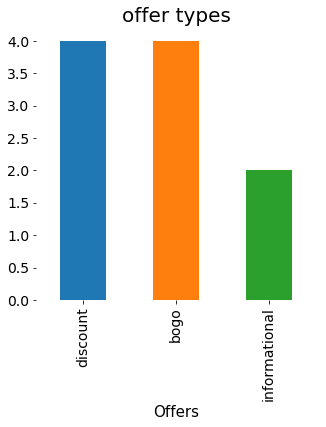

In [8]:
ax = portfolio["offer_type"].value_counts().plot.bar(
    figsize=(5,5),
    fontsize=14,

)

ax.set_title("offer types", fontsize=20)
ax.set_xlabel("Offers", fontsize=15)
sns.despine(bottom=True, left=True)

We can see from above that the portfolio table consists of information about the offers provided. It has channels through which the specific offers are given i.e email, web etc. 

histogram containing a distribution of 3 offer types totalling in 10 entries.

# 2. Access Profile data

In [9]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [10]:
profile.shape

(17000, 5)

In [11]:
profile.describe(include="all")

,age,became_member_on,gender,id,income
count,17000.000000,1.700000e+04,14825,17000,14825.000000
unique,NaN,NaN,3,17000,NaN
top,NaN,NaN,M,b5738353bbc84442ba74feef8930ccbe,NaN
freq,NaN,NaN,8484,1,NaN
mean,62.531412,2.016703e+07,NaN,NaN,65404.991568
std,26.738580,1.167750e+04,NaN,NaN,21598.299410
min,18.000000,2.013073e+07,NaN,NaN,30000.000000
25%,45.000000,2.016053e+07,NaN,NaN,49000.000000
50%,58.000000,2.017080e+07,NaN,NaN,64000.000000
75%,73.000000,2.017123e+07,NaN,NaN,80000.000000


In [12]:
#check for null values 
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [13]:
profile[profile['age']== 118].age.count()

2175

In [14]:
#We can drop lines with age = 118

profile[profile['age']== 118].drop(['became_member_on' ,'id'], axis=1)

,age,gender,income
0,118,None,NaN
2,118,None,NaN
4,118,None,NaN
6,118,None,NaN
7,118,None,NaN
9,118,None,NaN
10,118,None,NaN
11,118,None,NaN
17,118,None,NaN
23,118,None,NaN


In [16]:
#check for age above 80 and less than 118 

profile[(profile['age'] > 80) & (profile['age'] < 118)]

,age,became_member_on,gender,id,income
33,96,20171117,F,868317b9be554cb18e50bc68484749a2,89000.0
94,89,20171114,F,4264b1d027cc493281bba4f44bfedaca,87000.0
98,90,20151210,F,1c587de019994f93a242c6864fd7bc55,98000.0
126,83,20180127,M,4c29d22467af4d7faa137c4eedd65340,46000.0
131,89,20180114,F,3dae0eadb47149b0b9b548d14548524b,65000.0
167,85,20180726,M,4e233f02eff840c7a3e5ec15d55d7d23,67000.0
186,82,20161231,M,c79da41557894c7eacc5c0156dc1f4dc,87000.0
202,81,20180503,M,accec36a10704e1fbaeb9b28b8bc5da8,93000.0
210,82,20180319,M,d2e88e95c0ae41c0980e4cfc10d162d8,73000.0
214,82,20180108,M,5a3d291f75984396b6eb2800206ec716,72000.0


Applications usage is less for people with age > 80 we can assume that based on lines retreived.

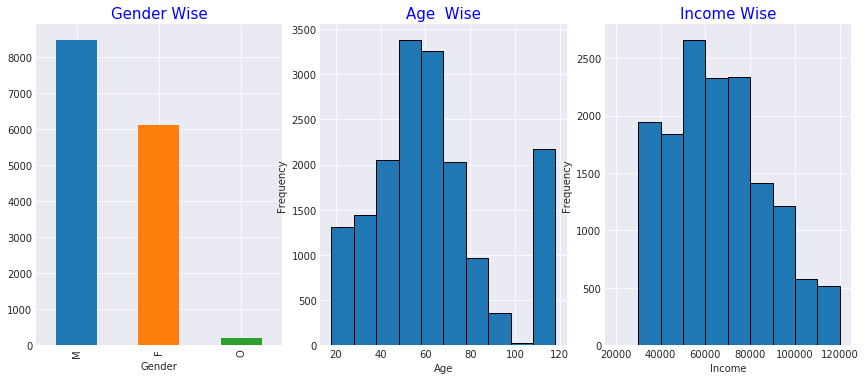

In [17]:
#Creating Subplots for distribution based on Gender,Age and Income
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,3,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()

# GENDER BASED
profile.gender.value_counts().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Gender Wise", fontsize=15,color='blue')
ax[0].set_xlabel("Gender", fontsize=10)
sns.despine(bottom=True, left=True)


# AGE BASED
profile.age.plot.hist(ax=ax[1],fontsize=10,edgecolor='black') 
ax[1].set_title("Age  Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Age", fontsize=10)
sns.despine(bottom=True, left=True)

# INCOME BASED
profile.income.plot.hist(ax=ax[2],fontsize=10,edgecolor='black',range=(20000, 120000)) 
ax[2].set_title("Income Wise", fontsize=15,color='blue')
ax[2].set_xlabel("Income", fontsize=10)
sns.despine(bottom=True, left=True)

plt.show()

Above is the distribution of data on age, income and gender basis.

Figures clearly shows that males utilize app more than females and age group from 50-70 is the highest, evenn income ramge from 60-80k are highest in using ap when compared to others.

Graphs may look slight differenr after cleaning the datasets and clearing null values.

# Access Transcript data

In [18]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [19]:
transcript.shape

(306534, 4)

In [20]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [21]:
# to understand different values in field value from transcript table.

transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

#  Data Cleaning

- Cleaning Portfolio

In [22]:
# portfolio: rename id col name to offer_id.

portfolio.rename(columns={'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}, inplace=True)

In [23]:
portfolio.columns

Index(['channels', 'offer_difficulty', 'offer_duration', 'offer_id',
       'offer_type', 'offer_reward'],
      dtype='object')

In [24]:
portfolio.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


# Cleaning Profile

- Renaming some columns for better readability .
- imputing null values with mean and mode to retain them
- identify age outlier and remove data from the set
- classify ages into bins.

In [25]:
# renaming columns
profile.rename(columns={'id':'customer_id' , 'income':'customer_income'}, inplace=True)

In [26]:
profile.columns

Index(['age', 'became_member_on', 'gender', 'customer_id', 'customer_income'], dtype='object')

In [27]:
def processed_profile(profile_df):
    """ 
    Cleans the profile_df data frame like replacing null values and creates bins groups for ages 
        
    Parameters
    ----------   
    profile_df: Input data frame
    
    Returns
    -------
    profile_df: output data frame after cleansing
    """
    
    
    #deal with null values
    #replace 118 age values with NaN so to replace them easily with mean age
    profile_df.replace(118, np.nan , inplace=True)
    
    #replace NaN age values with mean age
    profile_df['age'] = profile_df['age'].fillna(profile_df['age'].mean())
    
    #replace missing income values with mean income
    profile_df['customer_income'] = profile_df['customer_income'].fillna(profile_df['customer_income'].mean())
    
    #replace missing gender values with most frequent gender
    mode = profile_df['gender'].mode()[0]
    profile_df['gender'] = profile_df['gender'].fillna(mode)
    
    #remove outliers
    profile_df = profile_df[profile_df['age'] <= 80]
    profile_df['age'] = profile_df['age'].astype(int)
    
      
    #add Age_group column to set the age ranges
    profile_df.loc[(profile_df.age < 20) , 'Age_group'] = 'Under 20'
    profile_df.loc[(profile_df.age >= 20) & (profile_df.age <= 45) , 'Age_group'] = '20-45'
    profile_df.loc[(profile_df.age >= 46) & (profile_df.age <= 60) , 'Age_group'] = '46-60'
    profile_df.loc[(profile_df.age >= 61) , 'Age_group'] = '61-80'
    profile_df.drop('age',axis=1,inplace=True)
    
    return profile_df

In [28]:
processed_profile = processed_profile(profile)

In [29]:
processed_profile.head()

,became_member_on,gender,customer_id,customer_income,Age_group
0,20170212,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,46-60
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,46-60
2,20180712,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,46-60
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,61-80
4,20170804,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,46-60


In [30]:
#Re- check for missing values and null values , I have faced issues in downward steps with these so checking again.

processed_profile.isnull().sum()

became_member_on    0
gender              0
customer_id         0
customer_income     0
Age_group           0
dtype: int64

In [31]:
processed_profile.shape

(16014, 5)

# Cleaning transcript

- Rename cols
- Explore Value field to create columns from them again

In [32]:
# renaming columns to match with other dataframes

transcript.rename(columns={'person':'customer_id'}, inplace=True)

In [33]:
transcript.columns

Index(['event', 'customer_id', 'time', 'value'], dtype='object')

In [34]:
def processed_transcript(df):
    """
    Cleans the Transcript table by splitting value fileds and replacing nan values, drop extra columns
    PARAMETERS:
        transcript dataframe
    
    RETURNS:
        Cleaned transcript  dataframe
    
    """
    
    #expand the dictionary to coulmns (reward, amount, offre id) from value field
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['reward'] = df['value'].apply(lambda x: x.get('reward'))
    df['amount'] = df['value'].apply(lambda x: x.get('amount'))
    
    #move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    
    #drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    
    #replace nan
    df.fillna(0 , inplace=True)
    
    return df

In [35]:
processed_transcript = processed_transcript(transcript)

In [36]:
processed_transcript.head()

,event,customer_id,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [37]:
processed_transcript.shape

(306534, 6)

# Merge data frame for further analysis

In [38]:
def combine_data(portfolio,profile,transcript):
    """
    Merge data into single dataframe for analysis
       
    Parameters
    ---------- 
    portfolio :  portfolio data frame
    profile :  profile data frame
    transcript :  transcript data frame
      
    Returns
    -------
    returns merged data frame
    
    """
    
    # merge dataframes portfolio and transcript on offer_id's
    final_df = pd.merge(portfolio, transcript, on='offer_id')
    
    # merge dataframes final and profile on customer ids
    final_df = pd.merge(final_df, profile, on='customer_id')
    
    return final_df

In [39]:
final_df = combine_data(portfolio, processed_profile, processed_transcript)

In [40]:
final_df.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,reward,amount,became_member_on,gender,customer_income,Age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,M,100000.0,61-80


In [41]:
final_df.shape

(157503, 15)

In [42]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 15 columns):
channels            157503 non-null object
offer_difficulty    157503 non-null int64
offer_duration      157503 non-null int64
offer_id            157503 non-null object
offer_type          157503 non-null object
offer_reward        157503 non-null int64
event               157503 non-null object
customer_id         157503 non-null object
time                157503 non-null int64
reward              157503 non-null float64
amount              157503 non-null float64
became_member_on    157503 non-null int64
gender              157503 non-null object
customer_income     157503 non-null float64
Age_group           157503 non-null object
dtypes: float64(3), int64(5), object(7)
memory usage: 19.2+ MB


# We are trying to answer basic questions like to understand what events should be utilized while building model

- average Income
- Frequent offer used by customers
- what age group of males and females are doing better
- how different age groups respond to the offers

# Average income

In [43]:
final_df['customer_income'].mean()

65924.491099765321

the average income of customers is 65924 as of avaiable data after cleaning al null values and merging into single dataframe.


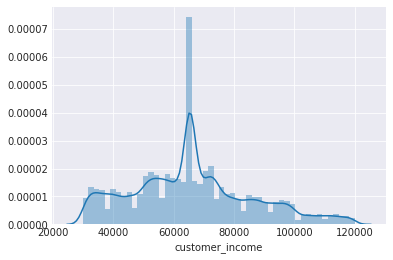

In [44]:
sns.distplot(final_df['customer_income'], bins=50, hist_kws={'alpha': 0.4});

# Frequently used offers by customers.

- BOGO is the most frequent offer availed by most of the users from availabe data and then followed by discounts

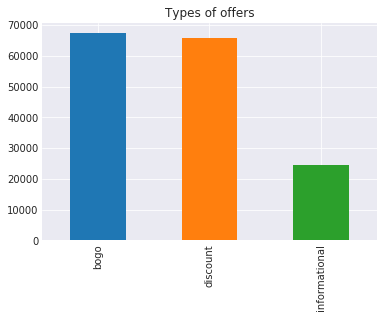

In [45]:
final_df['offer_type'].value_counts().plot.bar(title='Types of offers')

# How different genders respond to the offers.

There are three types of responses corresponding to each offer
- offer received
- offer viewed
- offer completed

In [46]:
plot_gender = final_df[final_df['gender'] != 'O']

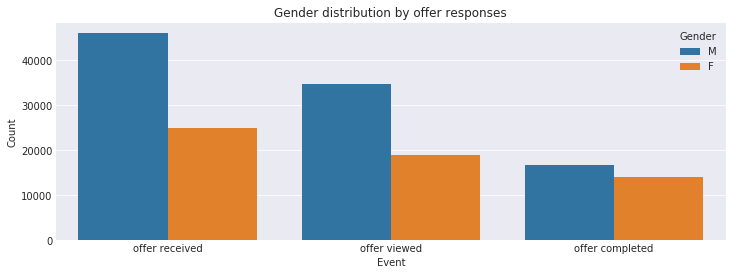

In [47]:
plt.figure(figsize=(12, 4))
sns.countplot(x= "event", hue= "gender", data=plot_gender)
plt.title('Gender distribution by offer responses')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

we can clearly say that most number of males receive offers but offer completion is seen almost equal in both males and females.

which means we can understand that irrespective of offer being received and offer viewed , offer will be completed.

This will be key point while building model, we can consider all lines with different responses than only going for 'offer completion'

#  Different age groups repond to offers

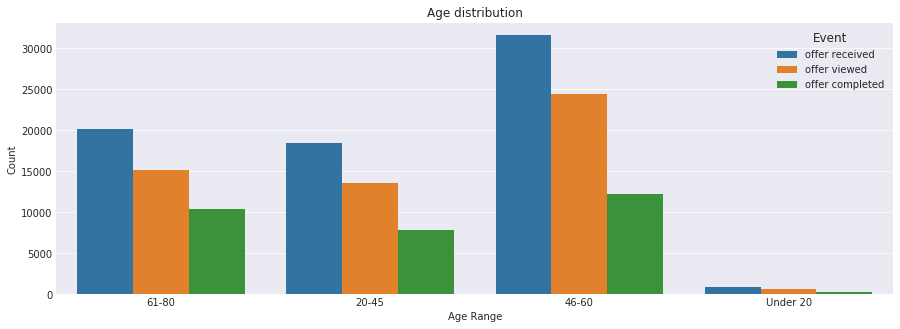

In [48]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "event", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Age distribution')
plt.ylabel('Count')
plt.xlabel('Age Range')
plt.legend(title='Event')

Here we can just look at the offer completion rate across differnt age groups to understand that we can send offers to all customers irrespective if they have previously received and viewed an offer.

which means while building model we can cosnider all types of events make predictions which will add weightage to the features.

# Build Model to predict Responses.

In [49]:
final_df.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,reward,amount,became_member_on,gender,customer_income,Age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,M,100000.0,61-80


In [50]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 15 columns):
channels            157503 non-null object
offer_difficulty    157503 non-null int64
offer_duration      157503 non-null int64
offer_id            157503 non-null object
offer_type          157503 non-null object
offer_reward        157503 non-null int64
event               157503 non-null object
customer_id         157503 non-null object
time                157503 non-null int64
reward              157503 non-null float64
amount              157503 non-null float64
became_member_on    157503 non-null int64
gender              157503 non-null object
customer_income     157503 non-null float64
Age_group           157503 non-null object
dtypes: float64(3), int64(5), object(7)
memory usage: 19.2+ MB


- one-hot encode categorical data such as gender, offer type, channel and age groups.
- Encode the 'event' data to numerical values to cinsider all values while buidling model.
    offer received ---> 1
    offer viewed ---> 2
    offer completed ---> 3
- Encode offer id and customer id.
- Drop column 'became_member_on' and add separate columns for month and year.
- Scale and normalize numerical data for few columns.


In [51]:
def process_final_data(df):
    """
    Cleans merged data to prepare for building model without any string values in the columns.
    
    Parameters
    ----------
    Input df: input merged data frame
    
    Returns
    -------
    output df: cleaned data frame as per requirements
       
    """
    #process the categorical variables by giving them one-hot encode values.
    categorical_cols = ['offer_type', 'gender', 'Age_group']
    df = pd.get_dummies(df, columns = categorical_cols)
    
    #process channels column and drop when done 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    #process became_member_on column to change datatype of became_member_on and create month_member, year_member based it
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    
    #add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    
    #drop became_member_on column once requiered fields are created.
    df.drop('became_member_on',axis=1, inplace=True)    
    
    #process offer_id column to zip to dict
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    #encode 'event' data to numerical values according
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [52]:
final_data = process_final_data(final_df)

In [54]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 26 columns):
offer_difficulty            157503 non-null int64
offer_duration              157503 non-null int64
offer_id                    157503 non-null int64
offer_reward                157503 non-null int64
event                       157503 non-null int64
customer_id                 157503 non-null int64
time                        157503 non-null int64
reward                      157503 non-null float64
amount                      157503 non-null float64
customer_income             157503 non-null float64
offer_type_bogo             157503 non-null uint8
offer_type_discount         157503 non-null uint8
offer_type_informational    157503 non-null uint8
gender_F                    157503 non-null uint8
gender_M                    157503 non-null uint8
gender_O                    157503 non-null uint8
Age_group_20-45             157503 non-null uint8
Age_group_46-60             15750

In [55]:
#process numerical variables
#initialize a MinMaxScaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

numericals = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'reward', 'amount']
final_data[numericals] = scaler.fit_transform(final_data[numericals])


In [56]:
final_data.head(5)

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,reward,amount,customer_income,...,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,month_member,year_member
0,0.5,0.571429,0,1.0,1,0,0.000000,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
1,0.5,0.571429,0,1.0,2,0,0.142857,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
2,0.5,0.571429,0,1.0,1,0,0.705882,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
3,0.5,0.571429,0,1.0,2,0,0.714286,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
4,0.5,0.571429,0,1.0,3,0,0.714286,1.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017


In [57]:
final_data.columns

Index(['offer_difficulty', 'offer_duration', 'offer_id', 'offer_reward',
       'event', 'customer_id', 'time', 'reward', 'amount', 'customer_income',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'gender_F', 'gender_M', 'gender_O', 'Age_group_20-45',
       'Age_group_46-60', 'Age_group_61-80', 'Age_group_Under 20', 'email',
       'mobile', 'social', 'web', 'month_member', 'year_member'],
      dtype='object')

In [58]:
final_data.event.value_counts()

1    71863
2    54396
3    31244
Name: event, dtype: int64

# Train and Test Data


In [59]:
features = final_data.drop('event', axis=1)
target = final_data['event']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 126002 rows
Testing set: 31501 rows


# Metrics

We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

F1-score is used when the False Negatives and False Positives are crucial, here in our case we need to avoid situation
- where they miss to send out offers to customer who actually completed previously (False Negative)
- Also, who didnt actually complete offer but are offered now (False Positive)

F1 score is reliable metric in cases of imbalanced dataset and traditional classification problems.

In [79]:
def train_test_data(clf):
    """
    Return train and test F1 score along with the models considered
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_pred =  (clf.fit(X_train, y_train)).predict(X_train)
    test_pred = (clf.fit(X_train, y_train)).predict(X_test)
    
    train_f1 =  accuracy_score(y_train, train_pred)*100
    test_f1= fbeta_score(y_test, test_pred, beta = 0.5, average='micro' )*100
    
    name_model = clf.__class__.__name__
    
    return train_f1, test_f1, name_model

In [80]:
clf_KNN = KNeighborsClassifier(n_neighbors = 5)


# train and test f1 score results are stored into bewlo varables.
K_train_f1, K_test_f1, K_model = train_test_data(clf_KNN)

#loading accuracy and f1score into variables.
knn = {'Model': [K_model], 'train F1 score':[K_train_f1], 'test F1 score': [K_test_f1]}

pd.DataFrame(knn)

,Model,train F1 score,test F1 score
0,KNeighborsClassifier,51.399978,28.767341


In [82]:
clf_dt = DecisionTreeClassifier(random_state = 10)

dt_train_f1, dt_test_f1, dt_model = train_test_data(clf_dt)

dt = {'Model': [dt_model], 'train F1 score':[dt_train_f1], 'test F1 score': [dt_test_f1]}

pd.DataFrame(dt)

,Model,train F1 score,test F1 score
0,DecisionTreeClassifier,93.941366,84.794134


Optimizing model using RandomForestClassifier and am making use of GridSearchCV to identify best parameters, through which best accuracy can be achevived.

In [101]:
#  Initialize the classifier
clf_ran = RandomForestClassifier(random_state =42, n_estimators=20)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'max_features':['auto', 'sqrt'], 'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]} 

#  Make an fbeta_score scoring object using make_scorer()
beta= 0.01

#  Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf_ran, parameters, cv=3, scoring='f1_macro')

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
train_pred =  (clf_ran.fit(X_train, y_train)).predict(X_train)
predictions = (clf_ran.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


ran_model = clf_ran.__class__.__name__
ran_train_f1 =  accuracy_score(y_train, train_pred)*100
ran_test_f1= fbeta_score(y_test, best_predictions, beta = beta, average='macro' )*100

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, average='macro', beta = beta)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, average='macro', beta = beta)))

Unoptimized model
------
Accuracy score on testing data: 0.6728
F-score on testing data: 0.7209

Optimized Model
------
Final accuracy score on the testing data: 0.7944
Final F-score on the testing data: 0.8421


In [102]:
model_comp = {'Model name': [ K_model, dt_model, ran_model], 
              'train F1 score': [K_train_f1 , dt_train_f1, ran_train_f1] ,
           'test F1 score': [K_test_f1 , dt_test_f1, ran_test_f1] }
          
pd.DataFrame(model_comp)

,Model name,train F1 score,test F1 score
0,KNeighborsClassifier,51.399978,28.767341
1,DecisionTreeClassifier,93.941366,84.794134
2,RandomForestClassifier,93.757242,84.206813


The test data setis used to evaluate the model. Both the models are better than the KNN. The best score is created by the DecisionTreeClassifier model, as its validate F1 score is 84.79, which is much higher than the benchmark.

The RandomForestClassifier model scores good as well compared to the DecisionTree, with a test F1 score of 84.30. Our problem to solve is not that sensitive which requires very high F1 score, so the scores are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer.


#  Exploratory Data Analysis

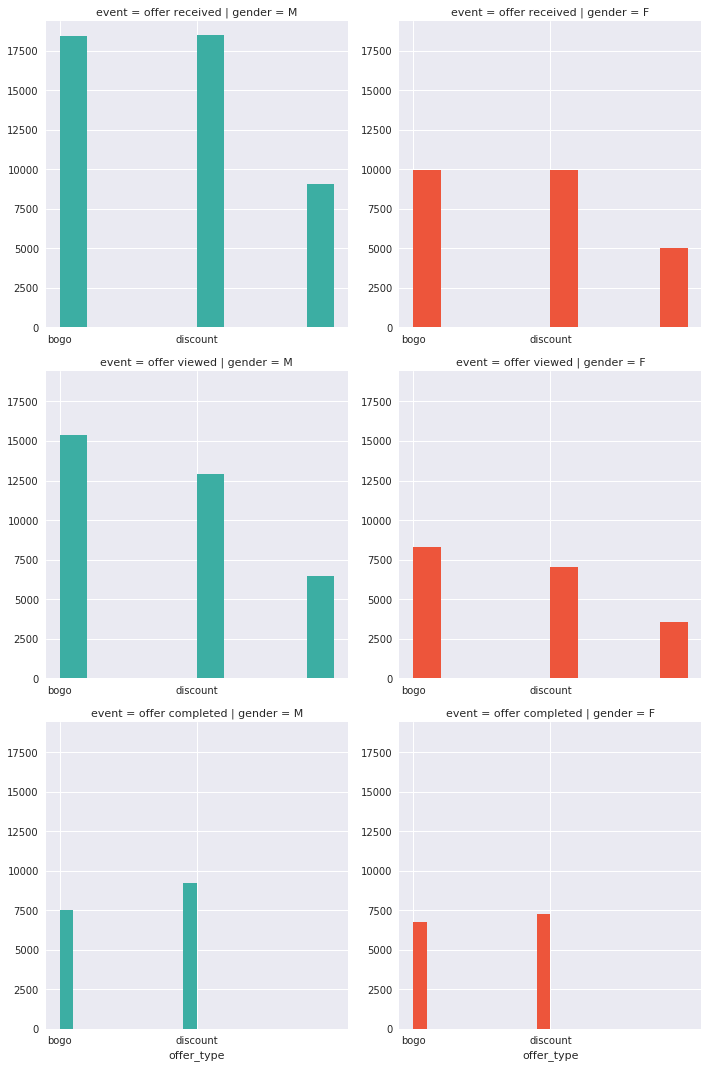

In [86]:
dis_col = {'color': [ '#3CAEA3','#ED553B']}

EDA = sns.FacetGrid(plot_gender, row='event', col='gender', hue_kws=dis_col, hue='gender', size=5)

EDA.map(plt.hist, 'offer_type')
plt.show()

we can clearly see here offer completion rate is low though offer is received or not, so we may need additinal features and more data to predict user behavior in responding to the offers.

with given data we can conclude that offers can be sent to members targeting income range 50-80k and for people whose age range is 46-60